In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()
import qiskit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi
import qiskit.quantum_info as qi

# Tomography Functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc
from qiskit.providers.aer import noise
from qiskit.providers.aer.noise import thermal_relaxation_error
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import AerSimulator



In [2]:
def state_transfer(N,alpha,beta):
    '''N = Number of qubits over which state is transferred
       State to be transferred:
       alpha|0> + beta|1>
       Equivalent to:
       abs(alpha)|0> + abs(beta)exp(i(arg(beta)-arg(alpha)))|1>
    '''
    qreg_q = QuantumRegister(N, 'q')
    circuit = QuantumCircuit(qreg_q)
    
    # Create the state to be transferred
    theta = 2*np.arccos(np.abs(alpha))
    phi = np.angle(beta) - np.angle(alpha)
    circuit.u3(theta,phi,0,qreg_q[0])
    
    # Create the state transfer CRX and CNOT gates
    for i in range(N-1):
        circuit.crx(np.pi,qreg_q[i],qreg_q[i+1])
        circuit.cx(qreg_q[i+1],qreg_q[i])
    return circuit,qreg_q

In [3]:
def noise_model_create(N,lam):
    '''
    Returns a noise model for N qubits with dephasing noise due to a phase damping channel with
    damping lambda (Reference Nielsen and Chuang)
    '''
    
    # Defining Kraus Operators:
    k1 = np.array([[1,0],[0,np.sqrt(1-lam)]])
    k2 = np.array([[0,0],[0,np.sqrt(lam)]])
    phase_damping = noise.kraus_error([k1,k2])
    
    
    # Add errors to noise model
    noise_dephase = NoiseModel()
    for j in range(N):
        noise_dephase.add_quantum_error(phase_damping, "reset", [j])
        noise_dephase.add_quantum_error(phase_damping, "measure", [j])
        noise_dephase.add_quantum_error(phase_damping, "u1", [j])
        noise_dephase.add_quantum_error(phase_damping, "u2", [j])
        noise_dephase.add_quantum_error(phase_damping, "u3", [j])
        for k in range(N):
            noise_dephase.add_quantum_error(phase_damping.expand(phase_damping), "cx", [j, k])
    
    return noise_dephase


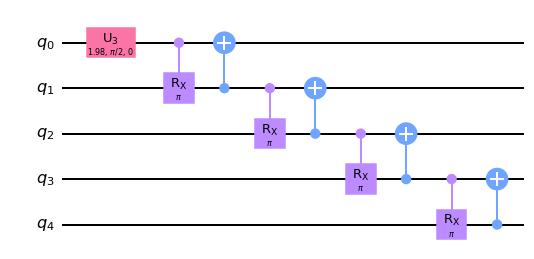

In [5]:
circ,q = state_transfer(5,alpha,beta)
circ.draw('mpl')

<ipython-input-4-49e3c24bd219>:8: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  circ_ideal.u3(theta,phi,0,q_ideal[0])


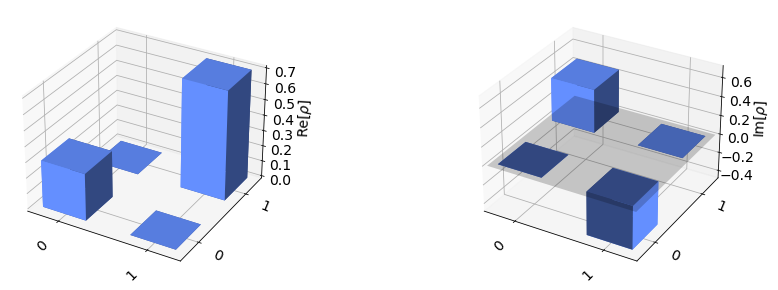

In [4]:
alpha = np.sqrt(0.3)
beta = np.sqrt(0.7)*1j
q_ideal = QuantumRegister(1,'q')
circ_ideal = QuantumCircuit(q_ideal)

theta = 2*np.arccos(np.abs(alpha))
phi = np.angle(beta) - np.angle(alpha)
circ_ideal.u3(theta,phi,0,q_ideal[0])

target_state_transfer = qi.Statevector.from_instruction(circ_ideal)
plot_state_city(target_state_transfer)
# print(target_state_transfer)

State Fidelity: F = 0.99528


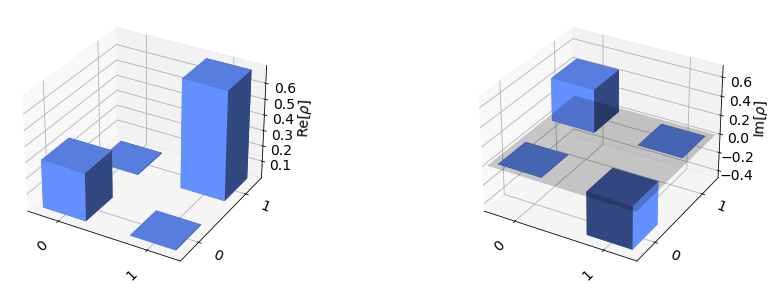

In [133]:
N = 5
circuit,q = state_transfer(N,alpha,beta)
qst_state_transfer = state_tomography_circuits(circuit, q[N-1])

# Execute
job = qiskit.execute(qst_state_transfer, Aer.get_backend('qasm_simulator'), shots=5000)

# Fit result
tomo_fitter_state_transfer = StateTomographyFitter(job.result(), qst_state_transfer)

# Perform the tomography fit
# which outputs a density matrix
rho_fit_state_transfer = tomo_fitter_state_transfer.fit(method='lstsq')
F_state_transfer = qi.state_fidelity(rho_fit_state_transfer, target_state_transfer)
print('State Fidelity: F = {:.5f}'.format(F_state_transfer))
plot_state_city(rho_fit_state_transfer)

In [137]:
#generate the calibration circuits
meas_calibs, state_labels = mc.complete_meas_cal(qubit_list=[N-1])
fidelity = []
lambdas = np.logspace(-3,0,50)
#Add noise
for lam in lambdas:
    noisemodel = noise_model_create(5,lam)

    # backend = Aer.get_backend('qasm_simulator')
    backend = AerSimulator(noise_model=noisemodel)
    
    job_cal = qiskit.execute(meas_calibs, backend=backend, shots=1024)

    job_tomo = qiskit.execute(qst_state_transfer, backend=backend, shots=1024)

    meas_fitter = mc.CompleteMeasFitter(job_cal.result(),state_labels)

    tomo_bell = StateTomographyFitter(job_tomo.result(), qst_state_transfer)

    
    #correct data
    correct_tomo_results = meas_fitter.filter.apply(job_tomo.result(), method='least_squares')
    tomo_state_transfer_mit = StateTomographyFitter(correct_tomo_results, qst_state_transfer)
    rho_fit_state_transfer_mit = tomo_state_transfer_mit.fit(method='lstsq')
    F_state_transfer_mit = qi.state_fidelity(rho_fit_state_transfer_mit, target_state_transfer)
    fidelity.append(F_state_transfer_mit)

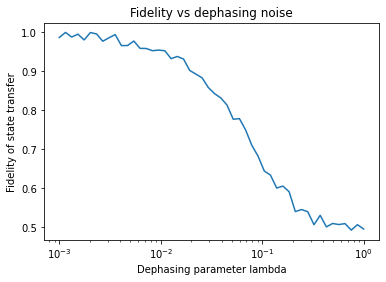

In [138]:
plt.semilogx(lambdas,fidelity)
plt.xlabel("Dephasing parameter lambda")
plt.ylabel("Fidelity of state transfer")
plt.title("Fidelity vs dephasing noise")
plt.show()

In [ ]:
backends = provider.backends('ibmq_bogota')
for i in range(len(backends)):
    print(backends[i].configuration().backend_name)

In [ ]:
circuit.draw('mpl')

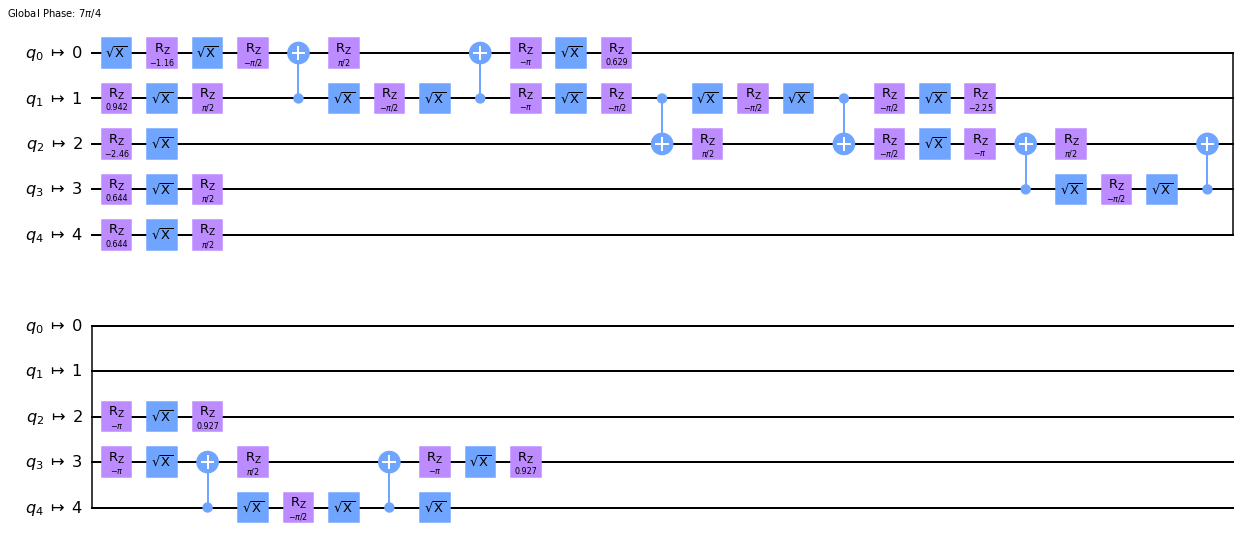

In [121]:
backend = provider.backends('ibmq_bogota')[0]
# print(type(backend[0]))
t_qc = transpile(circuit, backend, optimization_level=3)
t_qc.draw('mpl')

In [122]:
#Add measurement noise
noise_model = noise.NoiseModel.from_backend(backend)

#generate the calibration circuits
meas_calibs, state_labels = mc.complete_meas_cal(qubit_list=[4])

# backend = Aer.get_backend('qasm_simulator')
job_cal = qiskit.execute(meas_calibs, backend=backend, shots=1024)
job_tomo = qiskit.execute(qst_state_transfer, backend=backend, shots=1024)

meas_fitter = mc.CompleteMeasFitter(job_cal.result(),state_labels)

tomo_state_transfer = StateTomographyFitter(job_tomo.result(), qst_state_transfer)

#correct data
correct_tomo_results = meas_fitter.filter.apply(job_tomo.result(), method='least_squares')
tomo_state_transfer_mit = StateTomographyFitter(correct_tomo_results, qst_state_transfer)
rho_fit_state_transfer_mit = tomo_state_transfer_mit.fit(method='lstsq')
F_state_transfer_mit = qi.state_fidelity(rho_fit_state_transfer_mit, target_state_transfer)
print('State fidelity (w/ correction): F = {:.5f}'.format(F_state_transfer_mit))

State fidelity (w/ correction): F = 0.91355


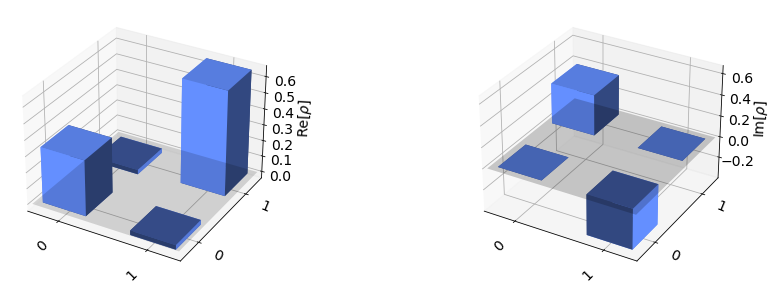

In [127]:
plot_state_city(rho_fit_state_transfer_mit)

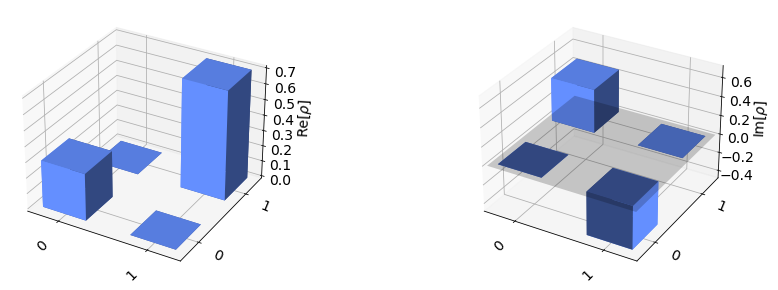

In [128]:
plot_state_city(target_state_transfer)